## PHYS-467 Machine Learning for Physicists. Exercise session 3

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import sklearn.linear_model as linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing

# Exercise 1: Linear Regression in 1D

The following function creates one dimensional linear data and add a gaussian noise i.e $y = a \times x + \varepsilon$

In [3]:
def generate_data(n_data, coefficient, variance):
    X = np.random.normal(size=(n_data,))
    y = X * coefficient + np.sqrt(variance) * np.random.normal(size=(n_data,))

    return X.reshape((-1, 1)), y

We can generate and plot some data (X, Y), along with the noiseless function $y = a \times x$

In [4]:
coefficient = 3
n_data      = 10
X, y = generate_data(n_data, coefficient, 0.5)
X.shape

(10, 1)

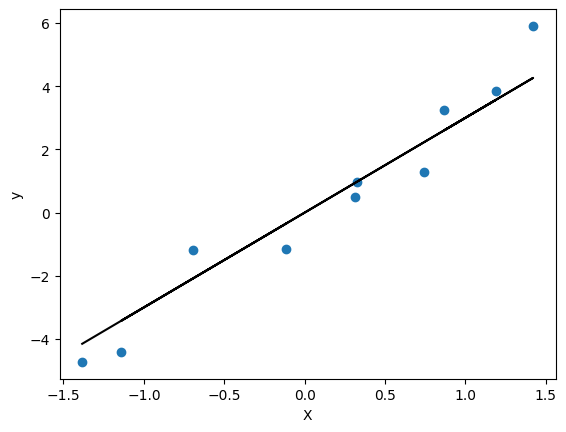

In [5]:
# Plot the training data

plt.scatter(X, y)
plt.xlabel('X')
plt.ylabel('y');

# ground truth 
plt.plot(X, coefficient * X, c='k')

**Question 1** Write a function to compute the least-square regression using the closed form seen in class.
Use this function on the  training data generated previously.

In [12]:
# Write a function to compute the linear-regression predictor in close form

def linear_regression(X, y):
    """
    arguments:
        - X : data matrix
        - y : output
    returns:
        - w : the least square estimator
    """
    X = np.concatenate((X, np.ones((len(X), 1))), axis=1)
    w = np.linalg.inv(X.T @ X) @ X.T @ y
    return w

In [13]:
# Print the predicted weights (coefficient + bias)

w = linear_regression(X, y)
w

array([ 3.45448602, -0.10194691])

**Question 3** Generate a grid of points and apply your predictor on this grid. Plot it along your training set.

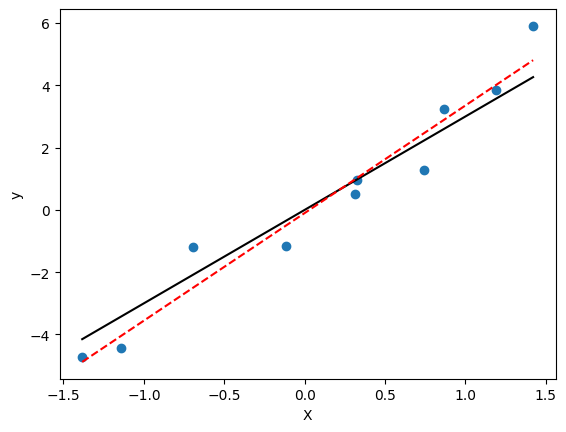

In [16]:
# Plot the training points and the predictor evaluated on a set of test points

X_test = np.linspace(np.min(X), np.max(X), 10)
y_test_pred = w[0]*X_test+w[1]

plt.scatter(X, y)
plt.plot(X_test, coefficient * X_test, 'k')
plt.plot(X_test, y_test_pred, 'r--')
plt.xlabel('X')
plt.ylabel('y');

**Question 4** Repeat the same with `LinearRegression` of the module [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Check that the coefficients are the same.

In [17]:
# Repeat with Scikit-learn

linear_regression_sk = LinearRegression()
linear_regression_sk.fit(X,y)
print('sklearn : ', linear_regression_sk.coef_, linear_regression_sk.intercept_)
print('w : ', w)

sklearn :  [3.45448602] -0.10194690768405223
w :  [ 3.45448602 -0.10194691]


# Exercise 2: Polynomial Regression, Underfitting & Overfitting

We first generate _noiseless_ points $x_1, ... x_n$ with few samples (say $5 \leqslant n \leqslant 10$) and $y_i = x_i^2$. Using [`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) from sklearn, we can fit polynomials of varying degrees $d$ on your training data.


In [18]:
def generate_data(polynome, bruit_std, n):
    """
    arguments:
        - polynome  : list of coefficients representing the polynom (polynome[i] multiplies X^i)
        - bruit_std : standard deviation of the gaussian noise
        - n         : number of data points
    returns: 
        - (X, y)    : list of n points with y = P(x) + gaussian noise
    """    
    degree  = len(polynome) - 1
    samples = np.random.uniform(-2, 2, size=n)
    xs      = np.copy(samples)
    samples = np.ones((n, degree + 1)).T * samples
    powers  = np.power(samples.T, np.arange(0, degree + 1, 1))
    return xs, np.sum(powers * polynome, axis = 1) + np.random.normal(0, bruit_std, size=n)

In [25]:
n       = 5
bound   = 3
# function y = x^2
polynom = np.array( [0, 0, 1] )

xs, ys   = generate_data(polynom, 0.0, n)

Here is how you fit the data : you first preprocess it (create the polynomial features) xs_trans, then do a linear regression.

Degree 1 : training error is 0.49400814727868864
Degree 3 : training error is 1.7749370367472766e-31
Degree 5 : training error is 1.2449827458101296e-29
Degree 7 : training error is 2.856194166869114e-28
Degree 9 : training error is 1.2045536244175528e-29


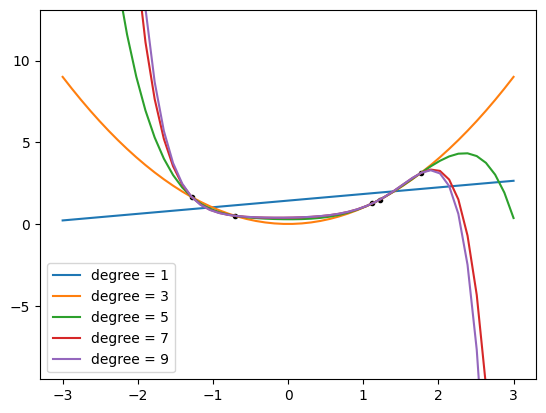

In [26]:
# Fit the data

x_grid = np.linspace(-bound, bound, 50)

degrees = np.arange(1, 10, 2)
coefs = []


for d in degrees:
    poly     = preprocessing.PolynomialFeatures(d)
    xs_trans = poly.fit_transform(xs.reshape(-1, 1))
    x_grid_trans = poly.fit_transform(x_grid.reshape((-1, 1)))
    lr = linear_model.Ridge(alpha = 0.0, fit_intercept=False).fit(xs_trans, ys)
    y_pred = xs_trans @ lr.coef_
    coefs.append(lr.coef_)
    plt.plot(x_grid, x_grid_trans @ lr.coef_, label=f'degree = {d}')
    print(f'Degree {d} : training error is {mean_squared_error(ys, y_pred)}')

plt.scatter(xs, ys, marker='.', c='k')
plt.ylim(np.min(ys) - 10, np.max(ys) + 10)
plt.legend()

**Question 1** Now, we generate _noisy_ quadratic data (i.e $y = x^2 + \varepsilon$). Fit again polynoms of various degrees. Sample a large test set and plot the test error as a function of the degree $d$ of the predictor. Observe the under/overfitting phenomenon.

Add a $\ell_2$ regularisation term for the high-degree polynomial case. What happens ? Try to vary the strenth of the regularization.

Degree 1 : MSE is 14.14045880957118
Degree 2 : MSE is 2.0150954051747214
Degree 4 : MSE is 9.392307459465336
Degree 8 : MSE is 16928638.727472704


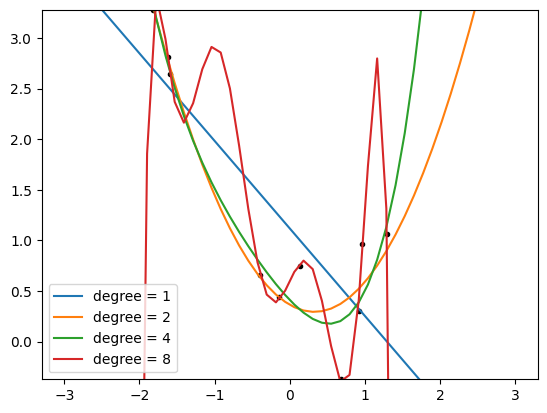

In [27]:
xs, ys  = generate_data(polynom, 0.5, 10)
y_true  = x_grid**2

degrees = np.array([1, 2, 4, 8])

plt.scatter(xs, ys, c='k', marker='.')

for d in degrees: 
    poly     = preprocessing.PolynomialFeatures(d)
    xs_trans = poly.fit_transform(xs.reshape(-1, 1))
    x_grid_trans = poly.fit_transform(x_grid.reshape((-1, 1)))
    lr = linear_model.Ridge(alpha = 0.0, fit_intercept=False).fit(xs_trans, ys)
    y_pred = lr.predict(x_grid_trans)
    plt.plot(x_grid, y_pred, label=f'degree = {d}')
    print(f'Degree {d} : MSE is {mean_squared_error(y_true, y_pred)}')

plt.legend()
plt.ylim(min(ys), max(ys))
plt.show()

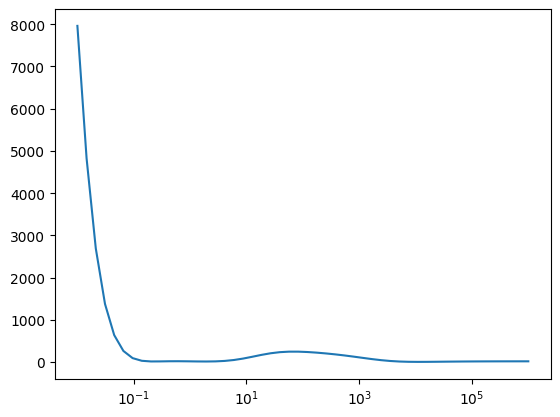

In [28]:
lambda_range = np.logspace(-2, 6, 50)
d = 6
ridge_mses = []

poly     = preprocessing.PolynomialFeatures(d)
xs_trans = poly.fit_transform(xs.reshape(-1, 1))
x_grid_trans = poly.fit_transform(x_grid.reshape((-1, 1)))
y_true = x_grid**2

for lambda_ in lambda_range:
    lr = linear_model.Ridge(alpha = lambda_, fit_intercept=False).fit(xs_trans, ys)
    y_pred = x_grid_trans @ lr.coef_
    ridge_mses.append(mean_squared_error(y_true, y_pred))

plt.semilogx(lambda_range, ridge_mses)


# Exercise 3: Real data

The superconductivity dataset [1] contains 81 chemical and molecular features extracted from 21263 superconductors along with the critical temperature (the label) in the 82nd column. The goal is to predict the critical temperature based on the 81 first features. If you are interested by the physical meaning of those 81 features, check out the original paper at https://arxiv.org/pdf/1803.10260.pdf !

[1] Hamidieh, Computational Materials Science, 2018

First, you need to download the dataset, in .csv format. You can find it here : https://archive.ics.uci.edu/dataset/464/superconductivty+data or on the Moodle.

Now, load the data. Since the format is .csv (data table), we used the Python module called pandas. If you are locally running the notebook, you need to indicate the path to it, e.g. "Downloads/train.csv". If you use colab, you have to upload it to colab (see the left hand side icon).

In [30]:
X=pd.read_csv("../superconductivity/train.csv",index_col=None)

In [33]:
X

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.00
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.00
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.00
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.00
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21258,4,106.957877,53.095769,82.515384,43.135565,1.177145,1.254119,146.88130,15.504479,65.764081,...,3.555556,3.223710,3.519911,1.377820,0.913658,1,2.168889,0.433013,0.496904,2.44
21259,5,92.266740,49.021367,64.812662,32.867748,1.323287,1.571630,188.38390,7.353333,69.232655,...,2.047619,2.168944,2.038991,1.594167,1.337246,1,0.904762,0.400000,0.212959,122.10
21260,2,99.663190,95.609104,99.433882,95.464320,0.690847,0.530198,13.51362,53.041104,6.756810,...,4.800000,4.472136,4.781762,0.686962,0.450561,1,3.200000,0.500000,0.400000,1.98
21261,2,99.663190,97.095602,99.433882,96.901083,0.690847,0.640883,13.51362,31.115202,6.756810,...,4.690000,4.472136,4.665819,0.686962,0.577601,1,2.210000,0.500000,0.462493,1.84


using .values() converts the table into a numpy array . Remember, the last column is the labels.

In [31]:
X_tot=X.values[:,:-1]
y_tot=X.values[:,-1]

In [37]:
print(y_tot.shape)
print(X_tot.shape)
print(y_tot.reshape(-1,1).shape)

(21263,)
(21263, 81)
(21263, 1)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_tot, y_tot, test_size=0.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.25)

Because different features correspond to different physical quantities and have different units, thus different magnitudes of numerical values, we preprocess the array.

In [34]:
scaler_X = preprocessing.StandardScaler().fit(X_train)
scaler_y = preprocessing.StandardScaler().fit(y_train.reshape(-1,1))

In [38]:
X_test=scaler_X.transform(X_test)
X_train=scaler_X.transform(X_train)
X_validation=scaler_X.transform(X_validation)


In [40]:
X_train.shape

(12757, 81)

**Question 1** Fit a linear model on the training set, and compute the predictions $\hat y$ of your model. Compare them to the true values $y^*$, for example by printing the mean squared error.

In [42]:
# Perform linear regression on the training set

linear_regression_sk = LinearRegression()
linear_regression_sk.fit(X_train, y_train)
print('sklearn : ', linear_regression_sk.coef_, linear_regression_sk.intercept_)

sklearn :  [  -5.32318661   26.13138804  -30.37873037  -17.31796078   24.37116692
  -13.09592456    1.02835059   11.3808096     0.38681807  -11.26975525
    2.15067022   21.50860526  -34.48921306  -18.99436485   31.58159375
  -57.33063256   13.84169626   22.19500671    3.47569998  -24.7160571
   -1.19600245  -10.61554437   95.60349269    4.30533987 -105.03101153
   37.2734885    19.43737545   12.94150201   -3.0961704    -7.73538068
   -8.12849922  -14.93216548   -0.43952768    6.77358416    8.52263348
    6.17601032   -5.65984032   -6.9627603     0.27427501   11.09243324
   -2.66366023   -1.67476807   17.2239355     4.22958099  -19.23328844
    1.88841161   -5.83880224  -20.93943022   -3.54417716   26.28066308
  -11.9027624    19.82868486  -28.52531999  -15.38488671   21.06950472
   -8.14763068    9.47488599   -9.49730155    7.09979876   -1.86288339
    4.51734644   -1.72308687   22.60530389   -3.02442494  -11.71379371
    2.99624668    0.74264574  -11.73839396   -9.53182292   13.61322

mse: 310.95312532986907


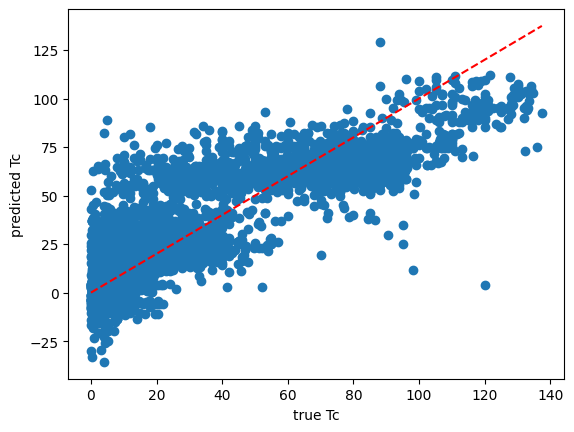

In [43]:
# Print the test error and plot the predicted critical temperatures vs the actual ones

y_pred = linear_regression_sk.predict(X_test)
print(f'mse: {mean_squared_error(y_test, y_pred)}')

plt.plot(np.linspace(np.min(y_test),np.max(y_test),100),np.linspace(np.min(y_test),np.max(y_test),100),ls="--",c="r")

plt.scatter(y_test, y_pred)
plt.xlabel('true Tc')
plt.ylabel('predicted Tc');

**Question 3** Redo the question 2 while varying the size of the training set. For each size, compute the training and test error. How do they vary as a function of the training size ? 

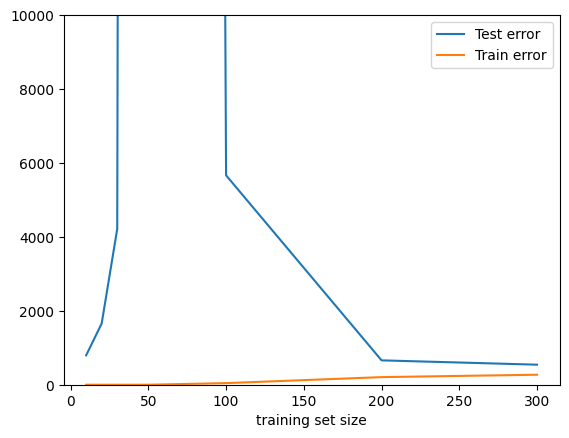

In [48]:
# Vary the training set size n and plot the learning curves (test and train error vs n)

trainset_sizes = [10, 20, 30, 50, 100, 200, 300]

train_errors = []
test_errors = []

for n in trainset_sizes:

    # Perform linear regression on the training set

    linear_regression_sk = LinearRegression()
    linear_regression_sk.fit(X_train[:n, :], y_train[:n])

    y_train_pred = linear_regression_sk.predict(X_train[:n, :])
    train_errors.append(mean_squared_error(y_train[:n], y_train_pred))

    y_test_pred = linear_regression_sk.predict(X_test)
    test_errors.append(mean_squared_error(y_test, y_test_pred))


plt.plot(trainset_sizes, test_errors, label='Test error')
plt.plot(trainset_sizes, train_errors, label='Train error')
plt.ylim(0,10000)
plt.xlabel('training set size')
plt.legend();

**Question 4** The function below generates _non-interactive_ polynomial features : for a degree $k$ and an input $x = x_1, ..., x_d$, generate $\tilde x = x_1, ..., x_1^k, x_2, ..., x_2^k, ... x_d^k$.
Run a linear regression on these polynomial features with different degrees $k$. 
Observe the under/overfitting phenomenon.

In [ ]:
# Implement *non-interacting* polynomial-features regression (not present in sklearn, write a function using numpy) and vary the degree from 1 to 6. Plot the results.


def non_interacting_polyfeat(X, k):
    """
    arguments: 
        - X : n x d matrix, where each row is a data sample
        - k : degree of the desired polynomial features
    returns: 
        - X2 : n x (dk) matrix containing the polynomial features
    """
    return np.concatenate([X**(i+1) for i in range(k)], axis=1)

train_errors = []
val_errors = []

ndegs = 10
for degree in range(1, ndegs):

    X_train_poly = non_interacting_polyfeat(X_train, degree)
    linear_regression_sk.fit(X_train_poly, y_train)
    y_train_pred_poly = ## your code here
    train_errors.append(mean_squared_error(y_train, y_train_pred_poly))

    y_val_pred_poly = ## your code here
    val_errors.append(mean_squared_error(y_validation, y_val_pred_poly))

plt.semilogy(np.arange(1,ndegs), train_errors, label='Train error')
plt.semilogy(np.arange(1,ndegs), val_errors, label='Validation error')
plt.xlabel('Degree (model complexity)')
plt.legend();

**Question 5** From the previous question, pick a degree that you think is best, and add different regularisation strength $\lambda$ to the regression. Plot the training and test errors as a function of $\lambda$.

In [ ]:
# Add different regularisers to the degree-6 model. Plot the results and find the best value.

best_degree = list(range(1, ndegs))[np.argmin(val_errors)]
print('Best degree is ', best_degree)

reg_strenghts = np.logspace(-12, 6, 20)

train_errors = []
val_errors_lambda = []

for reg_strenght in reg_strenghts:

    X_train_poly = non_interacting_polyfeat(X_train, k=best_degree)

    ridge_regression = ## your code here
    ## your code here
    
    y_train_pred_poly = ridge_regression.predict(X_train_poly)
    train_errors.append(mean_squared_error(y_train, y_train_pred_poly))

    y_val_pred_poly = ridge_regression.predict(non_interacting_polyfeat(X_validation, k=best_degree))
    val_errors_lambda.append(mean_squared_error(y_validation, y_val_pred_poly))

plt.loglog(reg_strenghts, train_errors, label='Train error')
plt.loglog(reg_strenghts, val_errors_lambda, label='Validation error')
plt.xlabel('$\lambda$')
plt.legend();

In [ ]:
lambda_opt = reg_strenghts[np.argmin(val_errors_lambda)]
print(f'Optimal lambda is {lambda_opt}, the validation error is {np.min(val_errors_lambda)}')

ridge_regression = Ridge(alpha=lambda_opt)
ridge_regression.fit(X_train_poly, y_train)

y_test_pred_poly = ridge_regression.predict(non_interacting_polyfeat(X_test, k=best_degree))
test_error = mean_squared_error(y_test, y_test_pred_poly)
print(f'Test error is {test_error}')

# Bonus for the curious: Spectrum of covariance in high dimensions

**Question 1** Consider $X$ a $n \times d$ Gaussian matrix. Compute and plot the spectrum of the covariance matrix $X^T X$ for dimension d = 50 and varying $n$. Look at the evolution of its rank as a function of $\alpha = n/d$. What happens at $\alpha = 1$ ?

In [ ]:
def generate_covariance_matrix(n, d):
    """
    arguments: 
        - n : number of samples
        - d : dimension
    returns:
        - covariance matrix of n x d matrix X
    """
    X = np.random.normal(size=(n, d))
    return X.T @ X / n

In [ ]:
# Compute the rank and plot the eigenvalues of the matrix X.T X varying alpha = n / d

d = 200
n_list = np.arange(int(0.1 * d), int(2 * d), 20)

rank_list = []

for n in n_list:

    cov = generate_covariance_matrix(n, d)
    rank = np.linalg.matrix_rank(cov)
    rank_list.append(rank)
    evals = np.linalg.eigh(cov)[0]
    evals = np.sort(evals)[::-1]

    plt.semilogy(evals, 'o')
    plt.xlabel(r'$\rho$')
    plt.ylabel(r'$\eta_{\rho}$')
    plt.title(f'$\\alpha = {n / d}')

    plt.show()

In [ ]:
plt.plot(n_list, rank_list, marker='.')
plt.show()

Question 3 Plot the behaviour of the test error vs alpha for noiseless high-dimensional linear data in the absence of noise. You can use  𝑑=100
  and  10⩽𝑛⩽500
 . What do you observe at  𝛼=1

In [ ]:
from sklearn.metrics import mean_squared_error

d = 100

train_set_sizes = np.array([500, 300, 200, 100, 50, 30, 20, 10])

X = np.random.rand(np.max(train_set_sizes) + 500, d)
w = 2 * np.random.randn(d, 1)
y = X.dot(w) + 2

mse = []
for n in train_set_sizes:
    X_train = X[:n]
    y_train = y[:n]
    linear_regression_sk.fit(X_train, y_train) # Fits the training data
    X_test = X[-500:]
    y_test = y[-500:]
    y_test_pred = linear_regression_sk.predict(X_test) # Predicts the labels of the test points
    mse.append(mean_squared_error(y_test, y_test_pred)) # Computes the mean squared error

plt.semilogx(train_set_sizes / d, mse, 'o')
plt.xlabel(r'$\alpha=\frac{n}{d}$')
plt.ylabel('Test error');